In [2]:
#Loading data and image plotting
import json
import cv2
import matplotlib.pyplot as plt
import os
from pathlib import Path

#NN
import keras
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

#Utility
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
#Used for mounting data from drive to GColab - leave out when running locally
from google.colab import drive
container_folder_abspath = Path('/content/myfiles')
gdrive_subfolder_relpath = Path('MyDrive/MVI/semestral_work')
drive.mount(str(container_folder_abspath))

this_file = "models/autoencoders/CNN_vae"
fullpath = container_folder_abspath / gdrive_subfolder_relpath / "mvi-sp" / this_file # Path objects with the operator /
%cd $fullpath
!pwd

Drive already mounted at /content/myfiles; to attempt to forcibly remount, call drive.mount("/content/myfiles", force_remount=True).
/content/myfiles/MyDrive/MVI/semestral_work/mvi-sp/models/autoencoders/CNN_vae
/content/myfiles/MyDrive/MVI/semestral_work/mvi-sp/models/autoencoders/CNN_vae


In [4]:
#Data preparation
with open('../../../data/cards_border1997.json', 'r') as f:
    cards_b1997_data = json.load(f)
with open('../../../data/cards_border2003.json', 'r') as f:
    cards_b2003_data = json.load(f)
with open('../../../data/cards_border2015.json', 'r') as f:
    cards_b2015_data = json.load(f)

In [5]:
cards_datasets = [cards_b2003_data]
cards_folders = ['art_border2003']
data = zip(cards_datasets,cards_folders)

images = []
card_metadata = []

for dataset,folder in data:
    print('Dataset folder: {}'.format(folder))
    for i,card in enumerate(dataset):
        img = cv2.imread('../../../data/preprocessed/136x100/{}.jpg'.format(card['id']))
        if img is None:
          print('{} not found.'.format(card['id']))
        else :
          images.append(img)
          card_metadata.append(card)
        if i % 200 == 0 and i != 0 :
            print('{} artworks loaded'.format(i))

Dataset folder: art_border2003
200 artworks loaded
400 artworks loaded
600 artworks loaded
800 artworks loaded
1000 artworks loaded
1200 artworks loaded
1400 artworks loaded
1600 artworks loaded
1800 artworks loaded
2000 artworks loaded
2200 artworks loaded
2400 artworks loaded
2600 artworks loaded
2800 artworks loaded
3000 artworks loaded
3200 artworks loaded
3400 artworks loaded
3600 artworks loaded
3800 artworks loaded
4000 artworks loaded
4200 artworks loaded
4400 artworks loaded
4600 artworks loaded
4800 artworks loaded


In [8]:
print(len(images))
print(images[0].shape)
print(len(card_metadata))

4836
(100, 136, 3)
4836


In [6]:
experiment_name = 'testing_experiment_CNN_vae_4'

input_size = images[0].shape[0]*images[0].shape[1]*images[0].shape[2]

x_images = np.array(images)
# x_images = x_images.reshape((len(images), input_size))

x_train,x_test,card_metadata_train, card_metadata_test = train_test_split(x_images,card_metadata,test_size=0.20,shuffle=False)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [7]:
input_img = keras.Input(shape=(100, 136, 3))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
# x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# # x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
# x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# # x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
preflatten_shape = K.int_shape(x)
latent_dim = np.prod(preflatten_shape[1:])
# x = layers.Flatten()(x)
z_mean = layers.Flatten()(x)
z_log_sigma = layers.Flatten()(x)


In [8]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])
# Create encoder
encoder = keras.Model(input_img, [z_mean, z_log_sigma, z], name='encoder')

In [8]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 136, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 100, 136, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 136, 16  2320        ['conv2d[0][0]']                 
                                )                                                           

In [9]:
preflatten_shape

(None, 25, 34, 64)

In [9]:
# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Reshape((preflatten_shape[1], preflatten_shape[2], preflatten_shape[3])) (latent_inputs)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu',padding='same')(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu',padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu',padding='same')(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)
decoded = layers.Cropping2D(cropping=((0, 0), (0, 0)))(x)
decoder = keras.Model(latent_inputs, decoded, name='decoder')

In [11]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 54400)]           0         
                                                                 
 reshape (Reshape)           (None, 25, 34, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 25, 34, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 25, 34, 64)       36928     
 ranspose)                                                       
                                                                 
 up_sampling2d (UpSampling2D  (None, 50, 68, 64)       0         
 )                                                               
                                                           

In [10]:
outputs = decoder(encoder(input_img)[2])
vae = keras.Model(input_img, outputs, name='cnn_vae')

In [13]:
vae.summary()

Model: "cnn_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 136, 3)]     0         
                                                                 
 encoder (Functional)        [(None, 54400),           72080     
                              (None, 54400),                     
                              (None, 54400)]                     
                                                                 
 decoder (Functional)        (None, 100, 136, 3)       108947    
                                                                 
Total params: 181,027
Trainable params: 181,027
Non-trainable params: 0
_________________________________________________________________


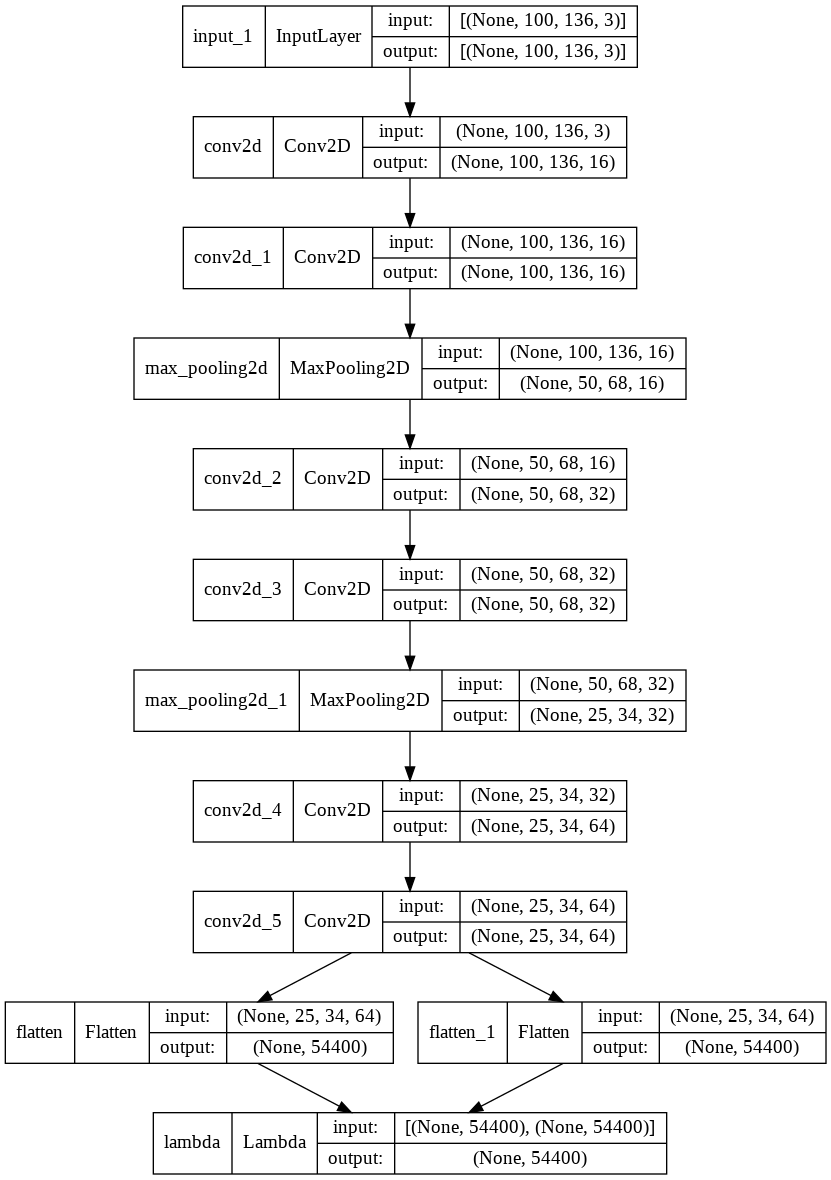

In [21]:
import tensorflow as tf
tf.keras.utils.plot_model(
    encoder,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [13]:
# reconstruction_loss = keras.losses.binary_crossentropy(input_img, outputs)
# reconstruction_loss *= original_dim
# kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
# kl_loss = K.sum(kl_loss, axis=-1)
# kl_loss *= -0.5
# vae_loss = K.mean(reconstruction_loss + kl_loss)
# vae.add_loss(reconstruction_loss)
# vae.add_loss(vae_loss)
vae.compile(optimizer='adam',loss='mse')


In [14]:
vae.fit(x_train, x_train,
        epochs=10,
        batch_size=256,
        validation_data=(x_test, x_test))

Epoch 1/10
16/16 [==============================] - 385s 24s/step - loss: 0.0571 - val_loss: 0.0328
Epoch 2/10
16/16 [==============================] - 386s 24s/step - loss: 0.0292 - val_loss: 0.0268
Epoch 3/10
16/16 [==============================] - 386s 24s/step - loss: 0.0254 - val_loss: 0.0247
Epoch 4/10
16/16 [==============================] - 384s 24s/step - loss: 0.0233 - val_loss: 0.0222
Epoch 5/10
16/16 [==============================] - 381s 24s/step - loss: 0.0190 - val_loss: 0.0183
Epoch 6/10
16/16 [==============================] - 379s 24s/step - loss: 0.0148 - val_loss: 0.0122
Epoch 7/10
16/16 [==============================] - 378s 24s/step - loss: 0.0115 - val_loss: 0.0110
Epoch 8/10
16/16 [==============================] - 379s 24s/step - loss: 0.0098 - val_loss: 0.0090
Epoch 9/10
16/16 [==============================] - 378s 24s/step - loss: 0.0088 - val_loss: 0.0079
Epoch 10/10
16/16 [==============================] - 378s 24s/step - loss: 0.0081 - val_loss: 0.0074

In [34]:
from math import ceil
earlyStop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

save_folder = 'model-checkpoints/{}'.format(experiment_name)
if not os.path.isdir(save_folder):
    print('Directory created')
    os.makedirs(save_folder)

batch_size = 256
save_every_n_epoch = 5
model_checkpoint_callback = ModelCheckpoint(
    filepath="model-checkpoints/{}".format(experiment_name)+"/prelim_{epoch:02d}",
    monitor="val_loss",
    save_freq=ceil(x_train.shape[0]/batch_size)*save_every_n_epoch)


In [35]:
#Additional training
vae.fit(x_train, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[earlyStop,model_checkpoint_callback])

Epoch 1/10
16/16 [==============================] - 380s 24s/step - loss: 0.0071 - val_loss: 0.0067
Epoch 2/10
16/16 [==============================] - 381s 24s/step - loss: 0.0069 - val_loss: 0.0065
Epoch 3/10
16/16 [==============================] - 382s 24s/step - loss: 0.0066 - val_loss: 0.0064
Epoch 4/10
16/16 [==============================] - 380s 24s/step - loss: 0.0061 - val_loss: 0.0060
Epoch 5/10
16/16 [==============================] - 390s 24s/step - loss: 0.0061 - val_loss: 0.0060
Epoch 6/10
16/16 [==============================] - 379s 24s/step - loss: 0.0059 - val_loss: 0.0056
Epoch 7/10
16/16 [==============================] - 383s 24s/step - loss: 0.0057 - val_loss: 0.0055
Epoch 8/10
16/16 [==============================] - 381s 24s/step - loss: 0.0056 - val_loss: 0.0052
Epoch 9/10
16/16 [==============================] - 383s 24s/step - loss: 0.0059 - val_loss: 0.0053
Epoch 10/10
16/16 [==============================] - 388s 24s/step - loss: 0.0055 - val_loss: 0.0058

In [11]:
vae = keras.models.load_model("model-checkpoints/{}".format(experiment_name)+"/final2")

In [36]:
#Save final model
# vae.save("model-checkpoints/{}".format(experiment_name)+"/final2")

INFO:tensorflow:Assets written to: model-checkpoints/testing_experiment_CNN_vae_4/final2/assets


In [12]:
for i in range(12):
  encoder.layers[i].set_weights(vae.layers[1].layers[i].get_weights())
  decoder.layers[i].set_weights(vae.layers[2].layers[i].get_weights())

In [13]:
encoded_imgs_test = encoder.predict(x_test)
decoded_imgs_test = decoder.predict(np.array(encoded_imgs_test)[0,:,:])

encoded_imgs_train = encoder.predict(x_train)
decoded_imgs_train = decoder.predict(np.array(encoded_imgs_train)[0,:,:])

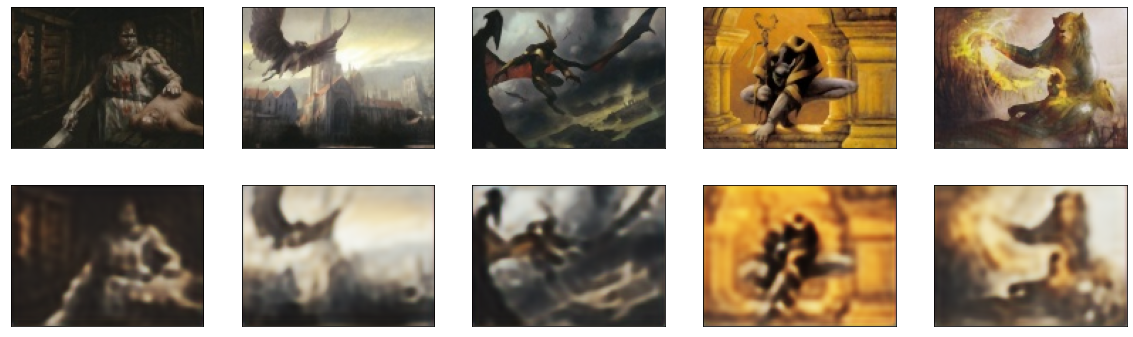

In [13]:
n = 5  # How many images we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cv2.cvtColor(x_train[i].reshape(100, 136,3), cv2.COLOR_BGR2RGB))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cv2.cvtColor(decoded_imgs_train[i].reshape(100, 136,3), cv2.COLOR_BGR2RGB))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

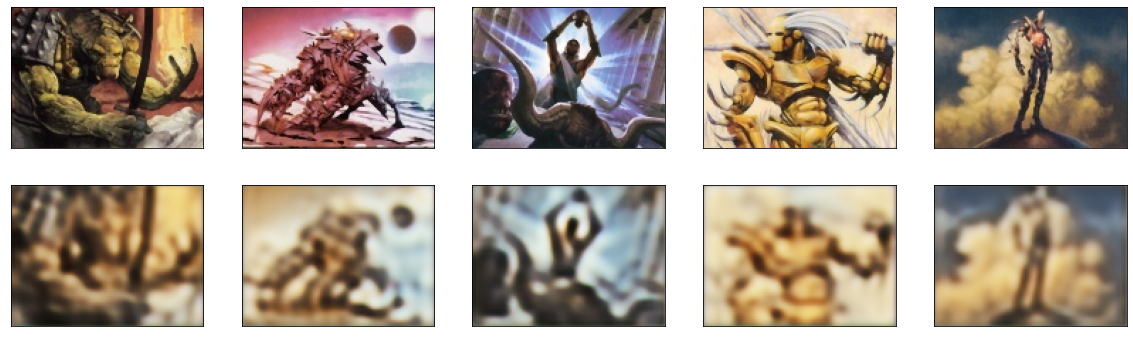

In [19]:
n = 5  # How many digits we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cv2.cvtColor(x_test[i].reshape(100, 136,3), cv2.COLOR_BGR2RGB))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cv2.cvtColor(decoded_imgs_test[i].reshape(100, 136,3), cv2.COLOR_BGR2RGB))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [20]:
 #Save results
save_folder = '../../../model_results/autoencoders/basic_autoencoder/{}/'.format(experiment_name)
if not os.path.isdir(save_folder):
    print('Directory created')
    os.makedirs(save_folder)

for original_img,c_metadata,reconstructed_img in list(zip(x_test,card_metadata_test,decoded_imgs_test))[:10]:
    cv2.imwrite('{}/{}_orig.png'.format(save_folder,c_metadata['id']), (original_img*255.).reshape(100, 136,3))
    cv2.imwrite('{}/{}_reconstructed.png'.format(save_folder,c_metadata['id']), (reconstructed_img*255.).reshape(100, 136,3))

Directory created


In [14]:
#Compute average images
searched_types = ['Dragon','Hydra','Zombie','Vampire','Spider','Kraken','Goblin','Shaman','Beast','Cat']
searched_types_encodings = []
for t in searched_types:
  ste = []
  for encim, cm in zip(encoded_imgs_train[0],card_metadata_train):
    if t in cm['type_line']:
      #  print(cm['type_line'])  
      ste.append(encim)
  print(len(ste))
  searched_types_encodings.append(ste)

73
20
172
69
28
6
165
195
143
68


In [20]:
encoded_means = []
encoded_mean_of_first_two = []
encoded_mean_of_first_four = []
for t,encs in zip(searched_types,searched_types_encodings):
  searched_type_encodings_mean = np.mean(encs,axis=0)
  encoded_means.append(searched_type_encodings_mean)
  encoded_mean_of_first_two.append(np.mean(encs[:2],axis=0))
  encoded_mean_of_first_four.append(np.mean(encs[:4],axis=0))

In [25]:
np.array(encoded_means).shape

(10, 54400)

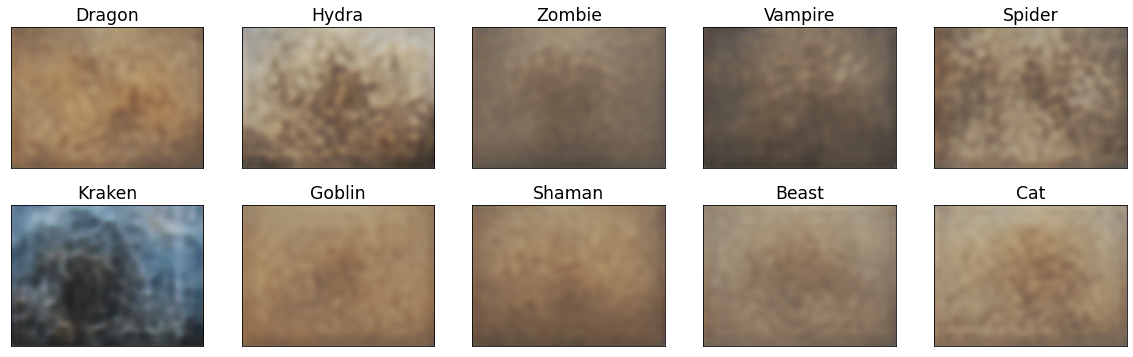

In [16]:
generated_images = decoder.predict(np.array(encoded_means).reshape(len(encoded_means),54400))
n = 5
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cv2.cvtColor(generated_images[i], cv2.COLOR_BGR2RGB))
    plt.title(searched_types[i],fontsize='xx-large')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cv2.cvtColor(generated_images[n+i], cv2.COLOR_BGR2RGB))
    plt.title(searched_types[n+i],fontsize='xx-large')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

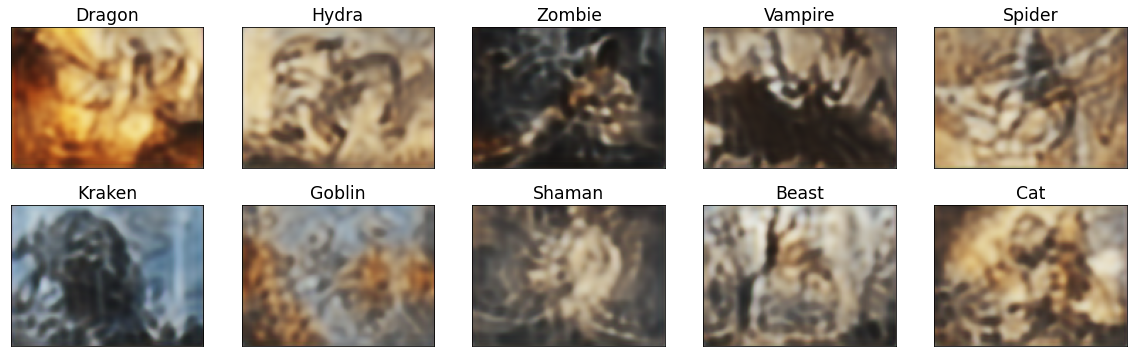

In [17]:
generated_images = decoder.predict(np.array(encoded_mean_of_first_two).reshape(len(encoded_means),54400))
n = 5
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cv2.cvtColor(generated_images[i], cv2.COLOR_BGR2RGB))
    plt.title(searched_types[i],fontsize='xx-large')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cv2.cvtColor(generated_images[n+i], cv2.COLOR_BGR2RGB))
    plt.title(searched_types[n+i],fontsize='xx-large')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

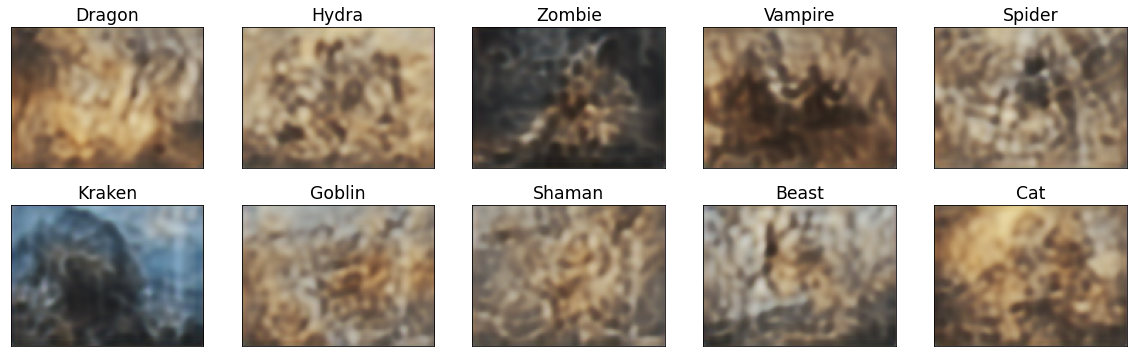

In [21]:
generated_images = decoder.predict(np.array(encoded_mean_of_first_four).reshape(len(encoded_means),54400))
n = 5
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cv2.cvtColor(generated_images[i], cv2.COLOR_BGR2RGB))
    plt.title(searched_types[i],fontsize='xx-large')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cv2.cvtColor(generated_images[n+i], cv2.COLOR_BGR2RGB))
    plt.title(searched_types[n+i],fontsize='xx-large')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [14]:
encoded_imgs_train[0][2].shape

(54400,)

In [27]:
encoded_vectors = []
for i in range(10):
  epsilon = np.random.normal(loc=0.0, scale=0.2, size=latent_dim)
  encoded_vectors.append(encoded_imgs_train[0][2] + np.exp(encoded_imgs_train[1][2]) * epsilon)

In [28]:
encoded_vector

array([ 0.01322267, -0.02298144, -0.07547792, ..., -0.14896807,
       -0.08555487, -0.16786977])

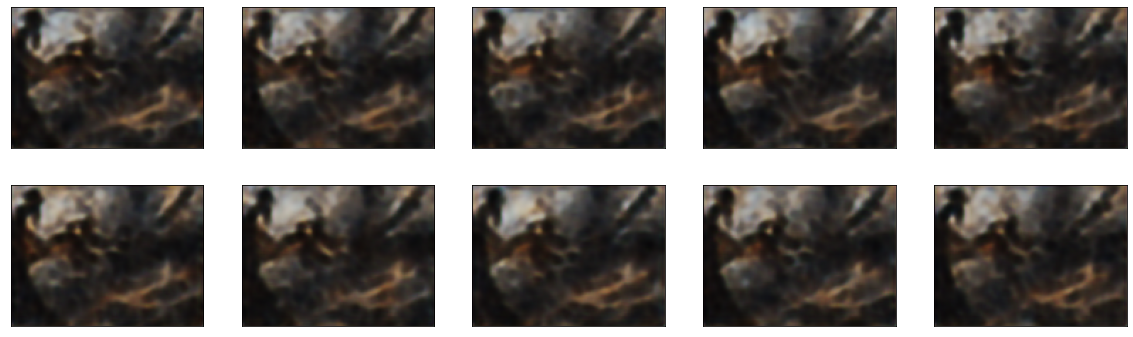

In [29]:
generated_images = decoder.predict(np.array(encoded_vectors).reshape(len(encoded_vectors),54400))
n = 5
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cv2.cvtColor(generated_images[i], cv2.COLOR_BGR2RGB))
    # plt.title(searched_types[i],fontsize='xx-large')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cv2.cvtColor(generated_images[n+i], cv2.COLOR_BGR2RGB))
    # plt.title(searched_types[n+i],fontsize='xx-large')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()